In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp

In [2]:
rootdir = "tiff/"
x_train_dir = os.path.join(rootdir, 'train')
y_train_dir = os.path.join(rootdir, 'train_labels')

x_valid_dir = os.path.join(rootdir, 'val')
y_valid_dir = os.path.join(rootdir, 'val_labels')

x_test_dir = os.path.join(rootdir, 'test')
y_test_dir = os.path.join(rootdir, 'test_labels')


In [3]:
classlabeldict = pd.read_csv("label_class_dict.csv")
clasnames = classlabeldict['name'].tolist()
class_rgb_values = classlabeldict[['r','g','b']].values.tolist()

In [4]:
clasnames

['background', 'building']

In [5]:
select_class_indices = [clasnames.index(cls.lower()) for cls in clasnames]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print(select_class_rgb_values)

[[  0   0   0]
 [255 255 255]]


In [6]:
def displayimages(**images):
    n_images = len(images)
    plt.figure(figsize=(16,8))
    for idx,(name,image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()
    
def onehotencode(label,labelvals):
    semanticmap = []
    for color in labelvals:
        equality = np.equal(label,color)
        classmap = np.all(equality,axis=-1)
        semanticmap.append(classmap)
    semanticmap = np.stack(semanticmap, axis=-1)
    return semanticmap

def reverseonehot(image):
    rev = np.argmax(image,axis=-1)
    return rev

def color_code_segment(image,labelvals):
    colorcodes = np.array(labelvals)
    ccs = colorcodes[image.astype(int)]
    return ccs

def training_augmentations():
    transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf([album.HorizontalFlip(p=1),album.VerticalFlip(p=1),album.RandomRotate90(p=1)],p=0.75)]
    return album.Compose(transform)

def validation_augmentations():   
    transform = [album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0)]
    return album.Compose(transform)

def convert_to_tensor(x,**kwargs):
    return x.transpose(2,0,1).astype("float32")

def func_for_preprocessing(preprocessing_fn=None):
    transform = []
    if preprocessing_fn:
        transform.append(album.Lambda(image=preprocessing_fn))
    transform.append(album.Lambda(image=convert_to_tensor,mask=convert_to_tensor))
    return album.Compose(transform)

def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,]
    
    

In [7]:
class DatasetCreation(torch.utils.data.Dataset):
    def __init__(self,images_dir,masks_dir,class_rgb_vals=None, augment=None,preprocess=None):
        self.imagespath = [os.path.join(images_dir,imageid) for imageid in sorted(os.listdir(images_dir))]
        self.maskspath = [os.path.join(masks_dir,maskid) for maskid in sorted(os.listdir(masks_dir))]
        self.class_rgb_vals = class_rgb_vals
        self.augment = augment
        self.preprocess = preprocess
        
    def __len__(self):
        return len(self.imagespath)
        
    def __getitem__(self,i):
        image = cv2.cvtColor(cv2.imread(self.imagespath[i]),cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.maskspath[i]),cv2.COLOR_BGR2RGB)
        mask = onehotencode(mask,self.class_rgb_vals).astype("float")
        if self.augment:
            sample = self.augment(image=image, mask=mask)
            image,mask = sample['image'],sample['mask']
        if self.preprocess:
            sample = self.preprocess(image=image,mask=mask)
            image,mask = sample['image'],sample['mask']
        return image,mask
    


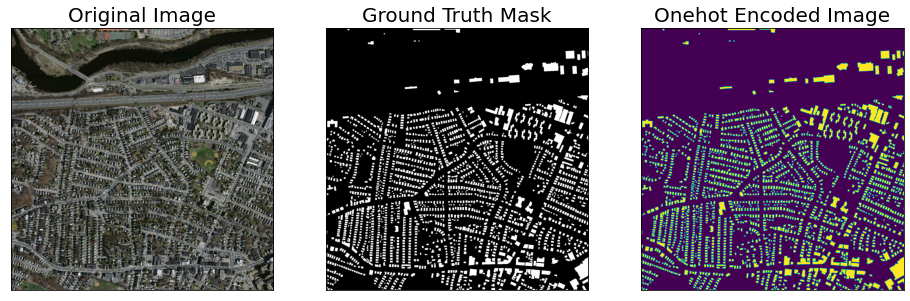

In [10]:
# ORIGINAL IMAGES

dataset = DatasetCreation(x_train_dir, y_train_dir, class_rgb_vals=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image,mask = dataset[random_idx]

displayimages(original_image=image,ground_truth_mask=color_code_segment(reverseonehot(mask),select_class_rgb_values),
             onehot_encoded_image = reverseonehot(mask))

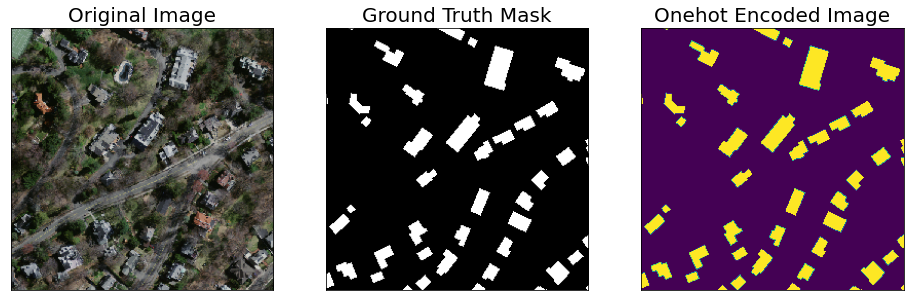

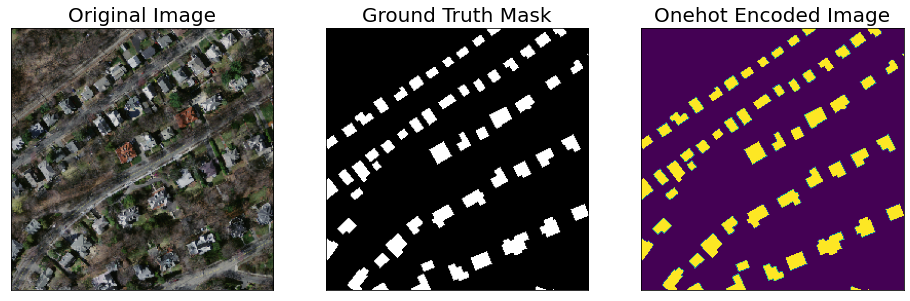

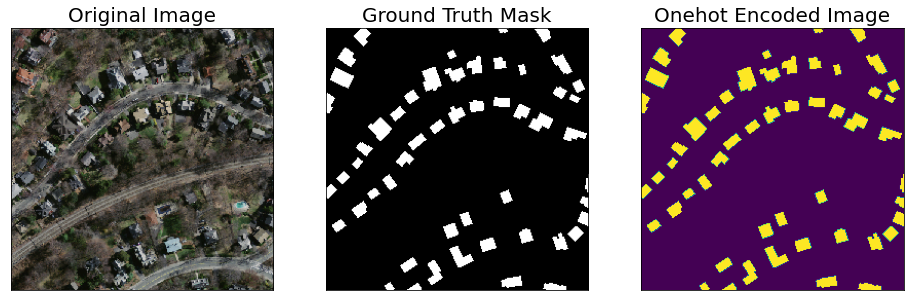

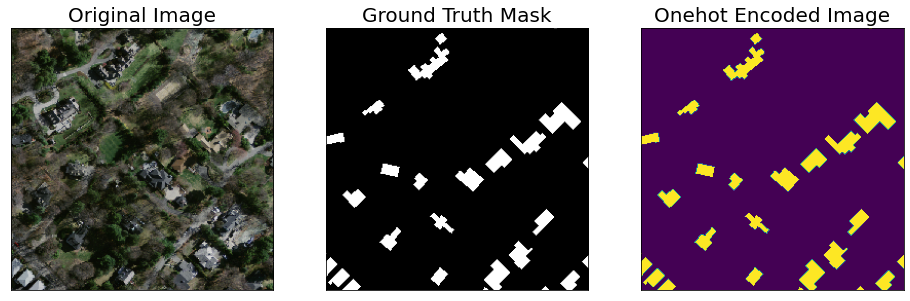

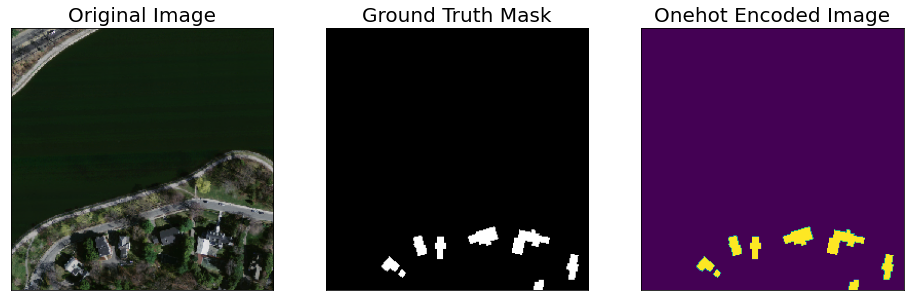

In [11]:
# AUGMENTED IMAGES

augment_dataset = DatasetCreation(x_train_dir, y_train_dir, class_rgb_vals=select_class_rgb_values,
                                  augment=training_augmentations())

random_idx = random.randint(0, len(augment_dataset)-1)

for i in range(5):
    image,mask = image,mask = augment_dataset[random_idx]
    displayimages(original_image=image,ground_truth_mask=color_code_segment(reverseonehot(mask),select_class_rgb_values),
             onehot_encoded_image = reverseonehot(mask))

In [67]:
# DeepLabV3 model 

encoder = "resnet101"
encoder_weights = "imagenet"
activation = "sigmoid"

model = smp.DeepLabV3Plus(encoder_name=encoder,encoder_weights=encoder_weights,\
                         classes=len(clasnames),activation="sigmoid")

preprocess_func = smp.encoders.get_preprocessing_fn(encoder,encoder_weights)

In [79]:
traindata = DatasetCreation(x_train_dir,y_train_dir,augment = training_augmentations(),
                           preprocess = func_for_preprocessing(preprocess_func),
                           class_rgb_vals = select_class_rgb_values)

validdata = DatasetCreation(x_valid_dir,y_valid_dir,augment = validation_augmentations(),
                           preprocess = func_for_preprocessing(preprocess_func),
                           class_rgb_vals = select_class_rgb_values)

trainloader = DataLoader(traindata,batch_size=16,shuffle=True)
validloader = DataLoader(validdata,batch_size=1,shuffle=False)

trainmodel = True
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)

if os.path.exists('./deeplabv3-using-pytorch/best_model.pth'):
    model = torch.load('./deeplabv3using-pytorch/best_model.pth', map_location=device)

trainepoch = smp.utils.train.TrainEpoch(model,loss=loss,optimizer=optimizer,metrics=metrics,device=device,verbose=True)
validepoch = smp.utils.train.ValidEpoch(model,loss=loss,metrics=metrics,device=device,verbose=True)

In [80]:
if trainmodel:
    best_iou_score = 0.0 
    train_logs_list, valid_logs_list = [], []
    for i in range(0,epochs):
        print('\nEpoch: {}'.format(i))
        trainlogs = trainepoch.run(trainloader)
        validlogs = validepoch.run(validloader)
        train_logs_list.append(trainlogs)
        valid_logs_list.append(validlogs)
        if best_iou_score < validlogs['iou_score']:
            best_iou_score = validlogs['iou_score']
            torch.save(model, './best_model.pth')
    print("Model Training completed successfully ! Also model is saved")


Epoch: 0
valid: 100%|█████████████████████████████████████| 4/4 [00:34<00:00,  8.69s/it, dice_loss - 0.5382, iou_score - 0.4828]

Epoch: 1
valid: 100%|██████████████████████████████████████| 4/4 [00:34<00:00,  8.58s/it, dice_loss - 0.423, iou_score - 0.7043]

Epoch: 2
valid: 100%|█████████████████████████████████████| 4/4 [00:34<00:00,  8.61s/it, dice_loss - 0.3214, iou_score - 0.7787]

Epoch: 3
valid: 100%|█████████████████████████████████████| 4/4 [00:34<00:00,  8.61s/it, dice_loss - 0.3171, iou_score - 0.7567]

Epoch: 4
valid: 100%|█████████████████████████████████████| 4/4 [00:34<00:00,  8.59s/it, dice_loss - 0.2992, iou_score - 0.7559]
Model Training completed successfully ! Also model is saved


In [83]:
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=device)
    print('Loaded DeepLabV3+ model from this run.')
    

Loaded DeepLabV3+ model from this run.


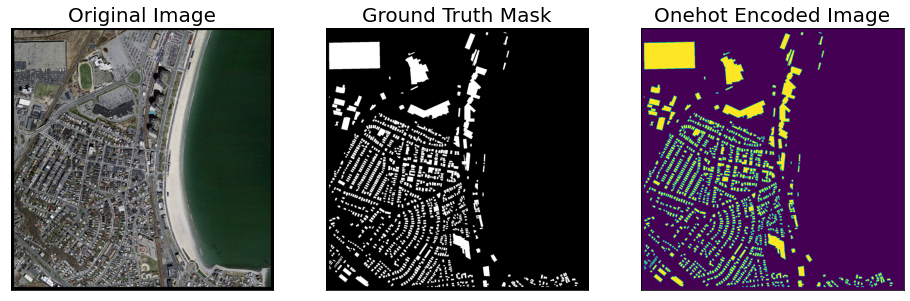

In [196]:
testdata = DatasetCreation(x_test_dir,y_test_dir,augment = validation_augmentations(),
                           preprocess = func_for_preprocessing(preprocess_func),
                           class_rgb_vals = select_class_rgb_values)

testloader = DataLoader(testdata)

testdata_without_preprocess = DatasetCreation(x_test_dir,y_test_dir,augment = validation_augmentations(),
                           class_rgb_vals = select_class_rgb_values)

random_idx = random.randint(0, len(testdata_without_preprocess)-1)
image, mask = testdata_without_preprocess[random_idx]

displayimages(original_image=image,ground_truth_mask=color_code_segment(reverseonehot(mask),select_class_rgb_values),
             onehot_encoded_image = reverseonehot(mask))

In [197]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

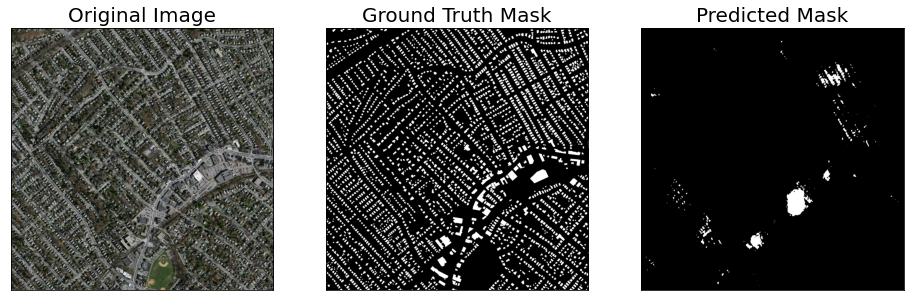

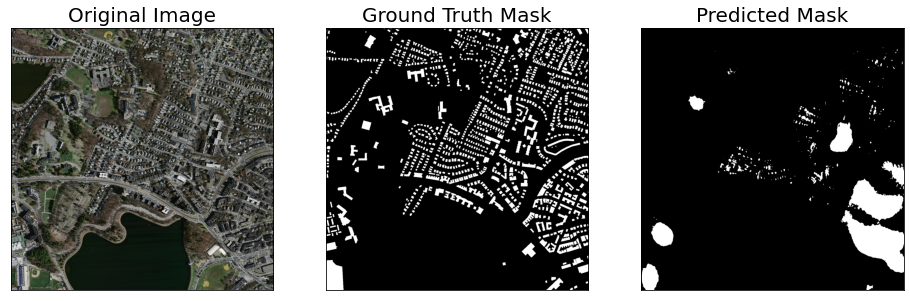

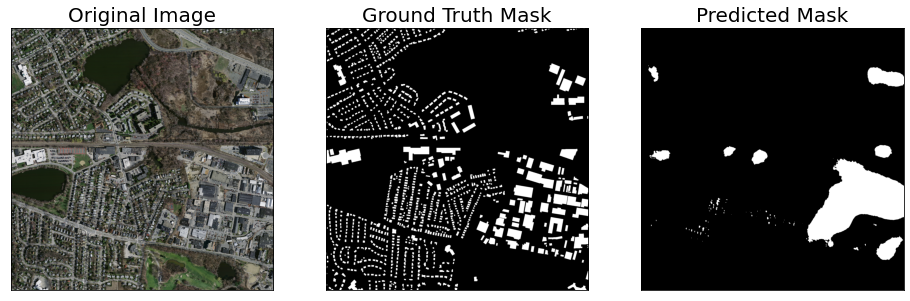

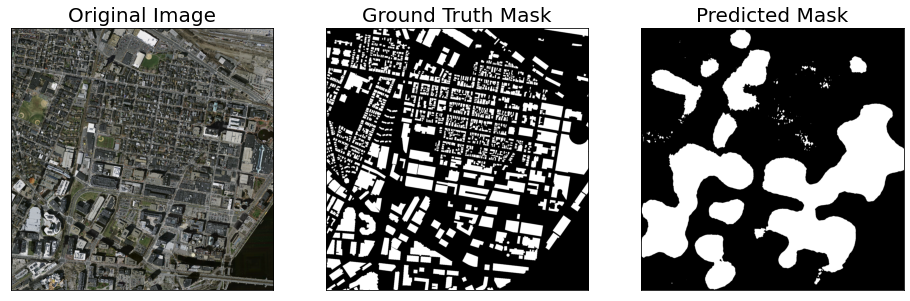

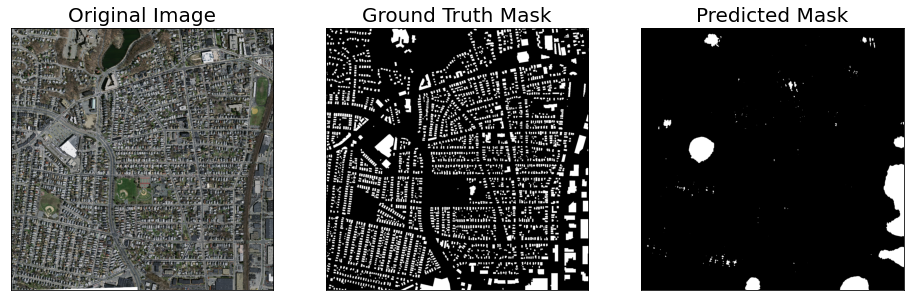

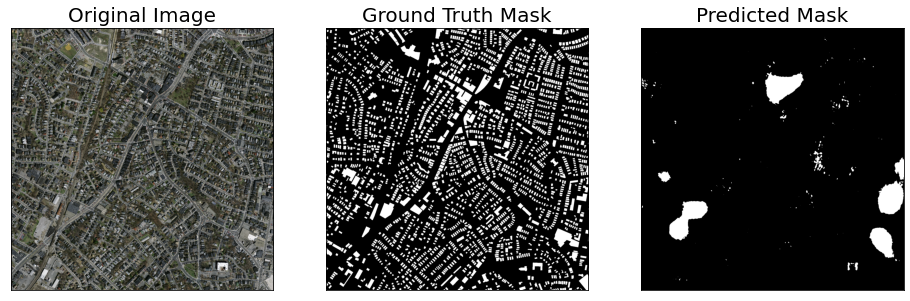

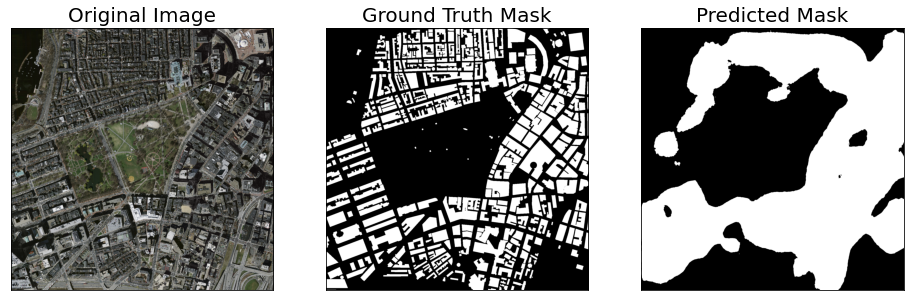

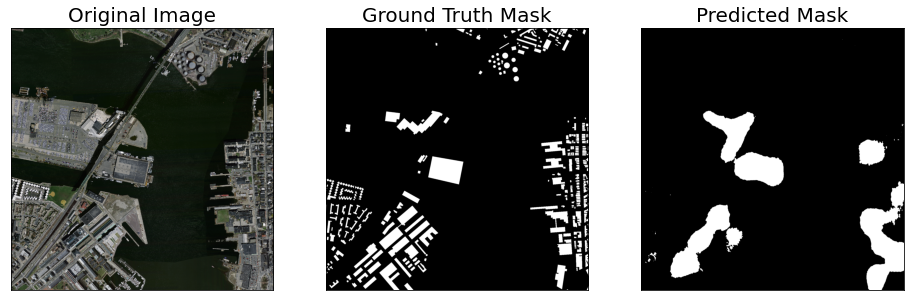

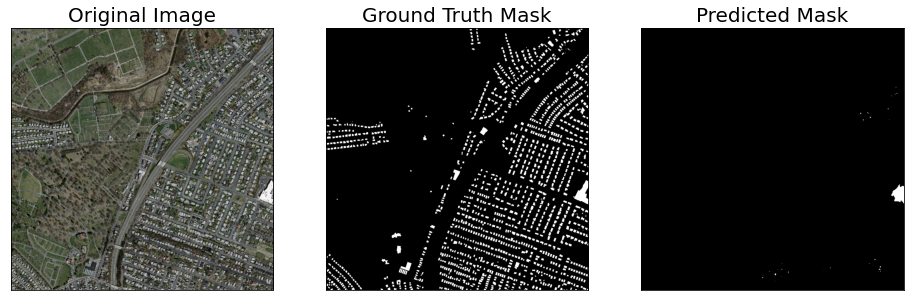

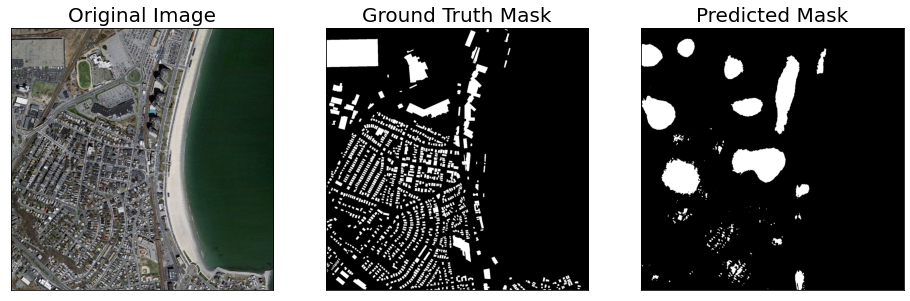

In [202]:
for idx in range(len(testdata)):

    image, gt_mask = testdata[idx]
    image_vis = crop_image(testdata_without_preprocess[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,clasnames.index('building')]
    pred_mask = crop_image(color_code_segment(reverseonehot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(color_code_segment(reverseonehot(gt_mask), select_class_rgb_values))
#     cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    displayimages(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask)

In [93]:
testepoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

valid_logs = testepoch.run(testloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|███████████████████████████████████| 10/10 [01:26<00:00,  8.64s/it, dice_loss - 0.3752, iou_score - 0.6202]
Evaluation on Test Data: 
Mean IoU Score: 0.6202
Mean Dice Loss: 0.3752


In [203]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

0         1         2         3         4
dice_loss  0.416698  0.375538  0.340345  0.320409  0.297167
iou_score  0.576488  0.635403  0.679313  0.691334  0.724438

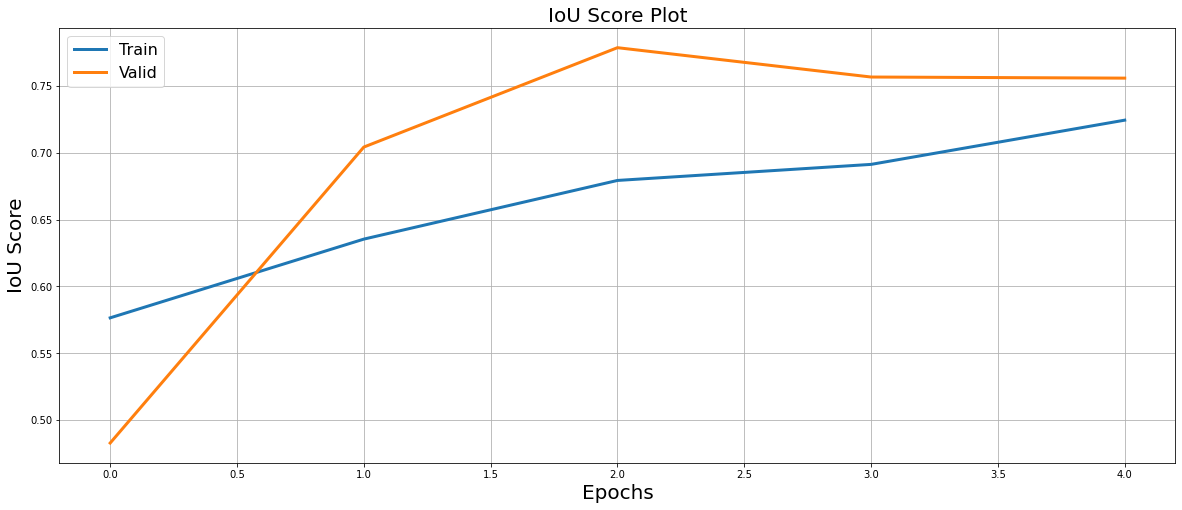

In [204]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.savefig('iou_score_plot.png')
plt.show()

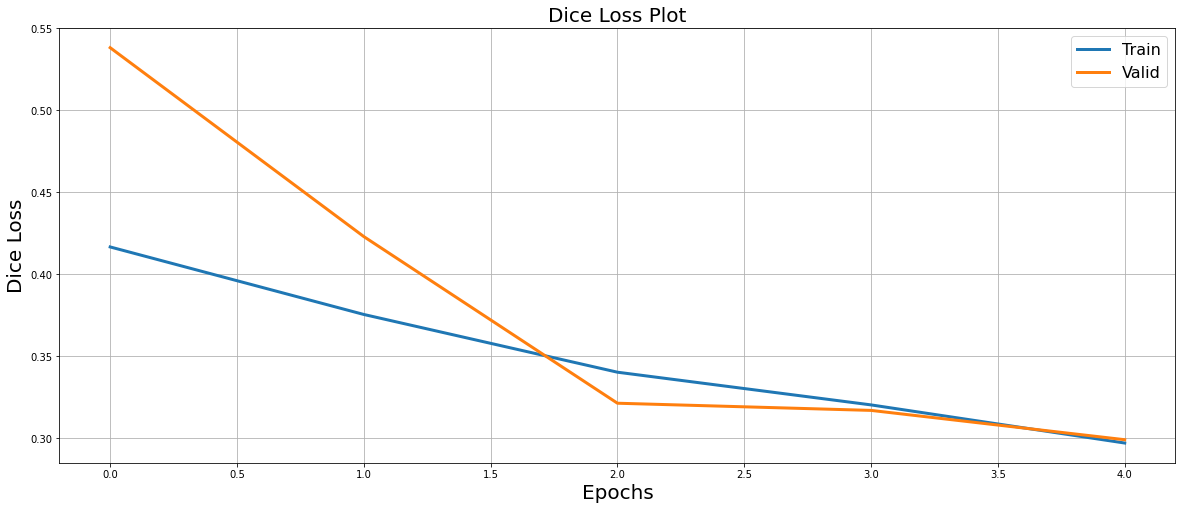

In [205]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.savefig('dice_loss_plot.png')
plt.show()